**Import the required dependencies**

In [ ]:
import open3d as o3d
import numpy as np
from functools import reduce
from operator import mul
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pytesseract
import os
from os.path import join

import math
import shutil
from moviepy.editor import *
from rlbench.demo import Demo
from rlbench.backend.observation import Observation
from pyrep.objects import VisionSensor
import pickle

import torch
from torch import nn

import trimesh, pyrender
import pyrender
from pyrender.trackball import Trackball
import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
DEFAULT_SCENE_SCALE = 2.0
CAMERAS = ['front']
VOXEL_SIZES = [200]
BATCH_SIZE = 1
DEFAULT_SCENE_SCALE = 2.0

**Helper Methods for generating point clouds**

In [21]:
def stack_on_channel(x):
    # expect (B, T, C, ...)
    return torch.cat(torch.split(x, 1, dim=1), dim=2).squeeze(1)

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

def _preprocess_inputs_new(rgb, point_cloud):
    obs, pcds = [], []

    rgb = stack_on_channel(rgb)
    pcd = stack_on_channel(point_cloud)

    rgb = _norm_rgb(rgb)

    obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
    pcds.append(pcd) # only pointcloud
    return obs, pcds

**Helper Methods for Creating and Displaying the Voxel Grids**

In [22]:
def _compute_initial_camera_pose(scene):
    print(scene)
    centroid = scene.centroid
    scale = scene.scale
    if scale == 0.0:
        scale = DEFAULT_SCENE_SCALE
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    return cp

def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr

def _create_bounding_box(scene, voxel_size, res):
    l = voxel_size * res
    T = np.eye(4)
    w = 0.01
    for trans in [[0, 0, l / 2], [0, l, l / 2], [l, l, l / 2], [l, 0, l / 2]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, w, l], T, face_colors=[0, 0, 0, 255]))
    for trans in [[l / 2, 0, 0], [l / 2, 0, l], [l / 2, l, 0], [l / 2, l, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [l, w, w], T, face_colors=[0, 0, 0, 255]))
    for trans in [[0, l / 2, 0], [0, l / 2, l], [l, l / 2, 0], [l, l / 2, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, l, w], T, face_colors=[0, 0, 0, 255]))


def create_voxel_scene(
        voxel_grid: np.ndarray,
        q_attention: np.ndarray = None,
        highlight_coordinate: np.ndarray = None,
        highlight_alpha: float = 1.0,
        voxel_size: float = 0.1,
        show_bb: bool = False,
        alpha: float = 0.5):

    _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)
    
    if highlight_coordinate is not None:
        x, y, z = highlight_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]
    
    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    if show_bb:
        assert d == h == w
        _create_bounding_box(scene, voxel_size, d)
    return scene


def visualise_voxel(voxel_grid: np.ndarray,
                    q_attention: np.ndarray = None,
                    highlight_coordinate: np.ndarray = None,
                    highlight_alpha: float = 1,
                    rotation_amount=(0,0,0),
                    show: bool = False,
                    voxel_size: float = 0.1,
                    offscreen_renderer: pyrender.OffscreenRenderer = None,
                    show_bb: bool = False):
    scene = create_voxel_scene(
        voxel_grid, q_attention, highlight_coordinate,
        highlight_alpha, voxel_size, show_bb)
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=640, viewport_height=480, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(np.deg2rad(rotation_amount[2]), np.array([0.0, 0.0, 1.0]))
        t.rotate(np.deg2rad(rotation_amount[1]), np.array([0.0, 1.0, 0.0]))
        t.rotate(np.deg2rad(rotation_amount[0]), np.array([1.0, 0.0, 0.0]))
        s.add(cam, pose=t.pose)
        color, depth = r.render(s)
        return color.copy()

In [23]:
def _compute_initial_camera_pose(scene):
    print(scene)
    centroid = scene.centroid
    scale = scene.scale
    if scale == 0.0:
        scale = DEFAULT_SCENE_SCALE
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    return cp

def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr

def _create_bounding_box(scene, voxel_size, res):
    l = voxel_size * res
    T = np.eye(4)
    w = 0.01
    for trans in [[0, 0, l / 2], [0, l, l / 2], [l, l, l / 2], [l, 0, l / 2]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, w, l], T, face_colors=[0, 0, 0, 255]))
    for trans in [[l / 2, 0, 0], [l / 2, 0, l], [l / 2, l, 0], [l / 2, l, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [l, w, w], T, face_colors=[0, 0, 0, 255]))
    for trans in [[0, l / 2, 0], [0, l / 2, l], [l, l / 2, 0], [l, l / 2, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, l, w], T, face_colors=[0, 0, 0, 255]))


def create_voxel_scene(
        voxel_grid: np.ndarray,
        q_attention: np.ndarray = None,
        highlight_coordinate: np.ndarray = None,
        highlight_alpha: float = 1.0,
        voxel_size: float = 0.1,
        show_bb: bool = False,
        alpha: float = 0.5):

    _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)
    
    if highlight_coordinate is not None:
        x, y, z = highlight_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]
    
    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    if show_bb:
        assert d == h == w
        _create_bounding_box(scene, voxel_size, d)
    return scene

def point_to_voxel_index(
        point: np.ndarray,
        voxel_size: np.ndarray,
        coord_bounds: np.ndarray):
    bb_mins = np.array(coord_bounds[0:3])
    bb_maxs = np.array(coord_bounds[3:])
    dims_m_one = np.array([voxel_size] * 3) - 1
    bb_ranges = bb_maxs - bb_mins
    res = bb_ranges / (np.array([voxel_size] * 3) + 1e-12)
    voxel_indicy = np.minimum(
        np.floor((point - bb_mins) / (res + 1e-12)).astype(
            np.int32), dims_m_one)
    return voxel_indicy


def visualise_voxel(voxel_grid: np.ndarray,
                    q_attention: np.ndarray = None,
                    highlight_coordinate: np.ndarray = None,
                    highlight_alpha: float = 1,
                    rotation_amount=(0,0,0),
                    show: bool = False,
                    voxel_size: float = 0.1,
                    offscreen_renderer: pyrender.OffscreenRenderer = None,
                    show_bb: bool = False):
    scene = create_voxel_scene(
        voxel_grid, q_attention, highlight_coordinate,
        highlight_alpha, voxel_size, show_bb)
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=640, viewport_height=480, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(np.deg2rad(rotation_amount[2]), np.array([0.0, 0.0, 1.0]))
        t.rotate(np.deg2rad(rotation_amount[1]), np.array([0.0, 1.0, 0.0]))
        t.rotate(np.deg2rad(rotation_amount[0]), np.array([1.0, 0.0, 0.0]))
        s.add(cam, pose=t.pose)
        color, depth = r.render(s)
        return color.copy()

In [24]:
MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = False


class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size,  # e.g. rgb or image features
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              ).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], ), max_dims,
             torch.tensor([4 + feature_size], )], -1).tolist()

        self.register_buffer('_ones_max_coords', torch.ones((batch_size, max_num_coords, 1)))
        self._num_coords = max_num_coords

        shape = self._total_dims_list
        result_dim_sizes = torch.tensor(
            [reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [1], )
        self.register_buffer('_result_dim_sizes', result_dim_sizes)
        flat_result_size = reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float)
        flat_output = torch.ones(flat_result_size, dtype=torch.float) * self._initial_val
        self.register_buffer('_flat_output', flat_output)

        self.register_buffer('_arange_to_max_coords', torch.arange(4 + feature_size))
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float)

        self._const_1 = torch.tensor(1.0, )
        self._batch_size = batch_size

        # Coordinate Bounds:
        bb_mins = self._coord_bounds[..., 0:3]
        self.register_buffer('_bb_mins', bb_mins)
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        dims_orig = self._voxel_shape_spec.int() - 2
        self.register_buffer('_dims_orig', dims_orig)

        # self._dims_m_one = (dims - 1).int()
        dims_m_one = (dims - 1).int()
        self.register_buffer('_dims_m_one', dims_m_one)

        # BS x 1 x 3
        res = bb_ranges / (dims_orig.float().to(device) + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float().to(device) - 2 + MIN_DENOMINATOR)
        self.register_buffer('_res', res)

        voxel_indicy_denmominator = res + MIN_DENOMINATOR
        self.register_buffer('_voxel_indicy_denmominator', voxel_indicy_denmominator)

        self.register_buffer('_dims_m_one_zeros', torch.zeros_like(dims_m_one))

        batch_indices = torch.arange(self._batch_size, dtype=torch.int).view(self._batch_size, 1, 1)
        self.register_buffer('_tiled_batch_indices', batch_indices.repeat([1, self._num_coords, 1]))

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, )
        index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])
        self.register_buffer('_index_grid', index_grid)

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):

        out = out.to(device).scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1
        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales.to(device)).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1]).to(device)
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None, kp_i=[0,0], im_size=(1668, 2388)):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float().to(device) + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one.to(device))
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros.to(device))

        # BS x NC x 3
        voxel_values = coords
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1)

        _, num_coords, _ = voxel_indices.shape
        # BS x N x (num_batch_dims + 2)
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords].to(device), voxel_indices], -1)
        
        temp = voxel_indices.reshape((im_size[1], im_size[0], 3))[kp_i[1], kp_i[0]]

        # BS x N x 4
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords].to(device)], -1)

        # BS x x_max x y_max x z_max x 4
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2].to(device) / self._voxel_d,
            vox[..., -1:]], -1), temp

In [25]:
# helper function for loading pkl files

def read_pickle(filename):
    
    with open(filename, "rb") as myfile:
        observations = pickle.load(myfile)
        
    return observations

In [26]:
def sort_paths(dirname):
    return [os.path.join(dirname, path) for path in sorted(os.listdir(dirname), key=lambda x: int(x[:-4]))]

**Visualising an episode from the training data**

In [27]:
SCENE_NAME = "on_lamp_new" 
EPISODE_NUMBER = 0

DATA_DIR = f"{SCENE_NAME}/all_variations/episodes/episode{EPISODE_NUMBER}"

RGB_PATHS = sort_paths(os.path.join(DATA_DIR, "front_rgb"))
DEPTH_PATHS = sort_paths(os.path.join(DATA_DIR, "front_depth"))
obs = read_pickle(os.path.join(DATA_DIR, "low_dim_obs.pkl"))

In [28]:
EXTRINSICS = obs[0].misc["front_camera_extrinsics"]
intrinsic = obs[0].misc["front_camera_intrinsics"]
CAMERA_FAR = obs[0].misc["front_camera_far"]
CAMERA_NEAR = obs[0].misc["front_camera_near"]
IMAGE_WIDTH, IMAGE_HEIGHT = Image.open(RGB_PATHS[0]).size

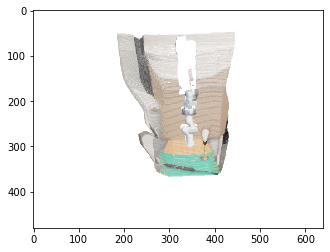

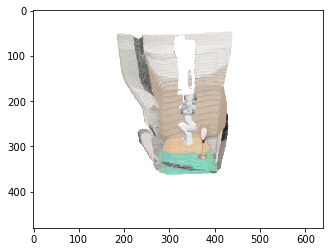

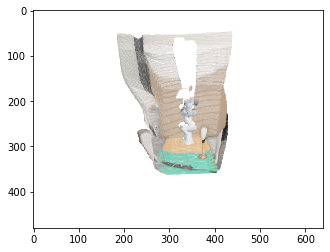

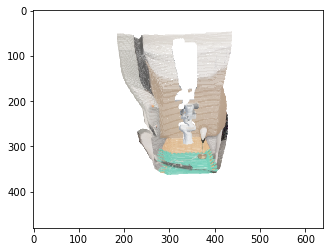

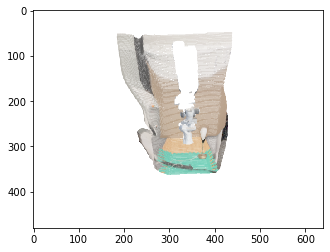

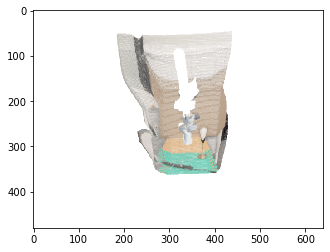

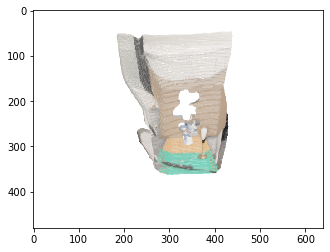

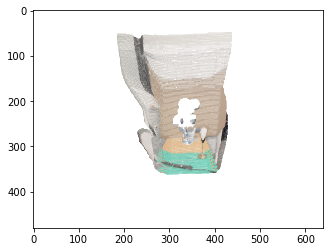

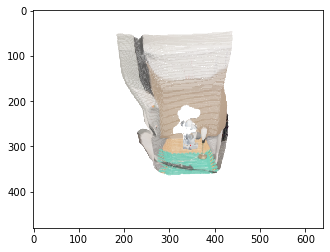

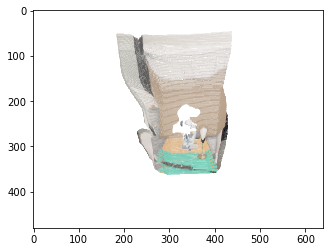

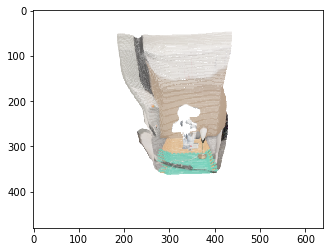

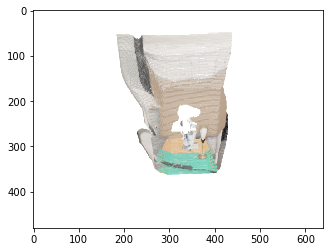

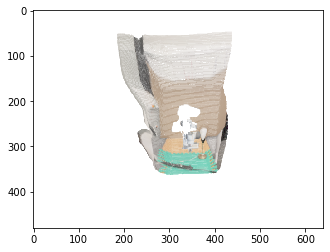

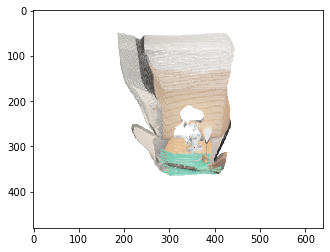

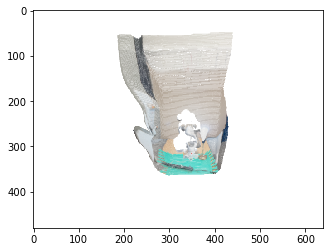

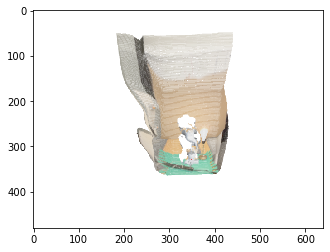

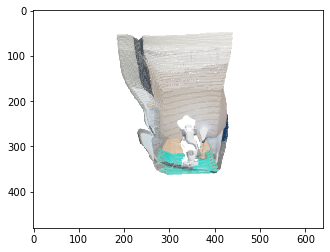

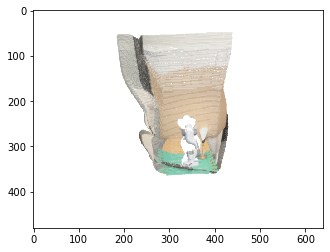

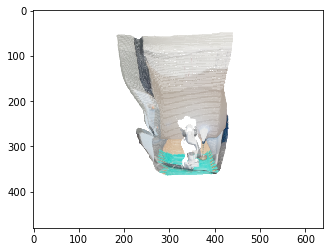

In [29]:
trans_points = [frame.gripper_pose[:3] for frame in obs]
voxel_indices = []
voxel_grids = []
scene_bounds_all = []

rotation_x= 0 
rotation_y= 0
rotation_z= 0

for kp_i, (rgb_path, depth_path) in enumerate(zip(RGB_PATHS, DEPTH_PATHS)):
    depth_img = np.array(Image.open(depth_path))
    rgb_img = np.array(Image.open(rgb_path))
    
    float_array = np.sum(depth_img * [65536, 256, 1], axis=2) /  16777215
    
    float_array = CAMERA_NEAR + float_array * (CAMERA_FAR - CAMERA_NEAR)
    
    
    pointcloud = VisionSensor.pointcloud_from_depth_and_camera_params(
                        float_array,
                        EXTRINSICS,
                        intrinsic)

    
    pcd_flat = pointcloud.reshape((-1,3))
    
    scene_bounds_min = [pcd_flat[:, i].min() for i in range(3)]
    scene_bounds_max = [pcd_flat[:, i].max() for i in range(3)]
    scene_bounds = scene_bounds_min + scene_bounds_max
    
    scene_bounds_all.append(scene_bounds)
                                  
    pcd_points_tensor = torch.Tensor(pcd_flat)
    
    
    vox_grid = VoxelGrid(
        coord_bounds=scene_bounds,
        voxel_size=VOXEL_SIZES[0],
        device=device,
        batch_size=BATCH_SIZE,
        feature_size=3,
        max_num_coords=np.prod([IMAGE_HEIGHT, IMAGE_WIDTH]) * len(CAMERAS),
    )

    pcd_flat = pcd_points_tensor.unsqueeze(0).to(device).to(torch.float32)


    flat_imag_features = torch.tensor(rgb_img.reshape(1, -1, 3))
    flat_imag_features = _norm_rgb(flat_imag_features).to(device)
    # tensorize scene bounds
    bounds = torch.tensor(scene_bounds, device=device).unsqueeze(0)
    

    # # voxelize!
    voxel_grid, _ = vox_grid.coords_to_bounding_voxel_grid(pcd_flat,
                                                        coord_features=flat_imag_features,
                                                        coord_bounds=bounds, kp_i=[0,0], 
                                                                     im_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()
    
    voxel_point = point_to_voxel_index(trans_points[kp_i], VOXEL_SIZES[0], scene_bounds)
    
    voxel_grids.append(vis_voxel_grid[0])
    
    
    plt.imshow(visualise_voxel(
                        vis_voxel_grid[0],
                        None,
                        voxel_point,
                        voxel_size=0.045,
                        highlight_alpha=1,
                        rotation_amount=(rotation_x,rotation_y,rotation_z)))
    plt.show()
    
scene_bounds_mean = np.array(scene_bounds_all).mean(axis=0)

In [30]:
def save_video(frames, filename, duration_per_frame=0.2):
    clips = [ImageClip(m).set_duration(0.2)
         for m in frames]
    concat_clip = concatenate_videoclips(clips, method="compose")
    concat_clip.write_videofile(filename, fps=24)

In [31]:
scene_bounds_mean = np.array(scene_bounds_all).mean(axis=0)

In [ ]:
rendered_images_rotation = []
num_images_per_frame = 3

for i in range(len(voxel_grids) * 3):
  rot_x = 0
  rot_y = 0
  rot_z =  90  - i*(20/ num_images_per_frame)
  rendered_img = visualise_voxel(voxel_grids[i // num_images_per_frame],
                                None,
                                point_to_voxel_index(trans_points[i // num_images_per_frame], 
                                                     VOXEL_SIZES[0], 
                                                     scene_bounds_mean),
                                voxel_size=0.045,
                                highlight_alpha=1,
                                rotation_amount=(rot_x,rot_y,rot_z)
                                )

  rendered_images_rotation.append(rendered_img)

save_video(rendered_images_rotation, "frames_with_rotation.mp4")